2 classes classification, rain tomorrow: yes/no

In [412]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [413]:
df = pd.read_csv('data/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [414]:
cols = ['WindGustSpeed','MaxTemp','MinTemp','Rainfall', 'Humidity3pm', 'Humidity9am','Pressure3pm','Pressure9am', 'RainToday', 'RainTomorrow','Temp3pm','Temp9am']
df = df[cols]

In [415]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

In [416]:
print(df.isna().sum())
print(len(df))
df = df.dropna(how='any')
print(len(df))


WindGustSpeed    10263
MaxTemp           1261
MinTemp           1485
Rainfall          3261
Humidity3pm       4507
Humidity9am       2654
Pressure3pm      15028
Pressure9am      15065
RainToday         3261
RainTomorrow      3267
Temp3pm           3609
Temp9am           1767
dtype: int64
145460
119702


In [417]:
X = df.drop(['RainTomorrow'],axis = 1)  
y = df[['RainTomorrow']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [418]:
BATCH_SIZE=32
EPOCH = 150

X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

train = torch.utils.data.TensorDataset(X_train,y_train)
validate = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([95761, 11]) torch.Size([95761])
torch.Size([23941, 11]) torch.Size([23941])


In [419]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [420]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 10)
    self.fc2 = nn.Linear(10, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))
net = Net(X_train.shape[1])

In [421]:
from tqdm.notebook import tqdm

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

predicted_list = []
train_acc_per_epoch = []
val_acc_per_epoch = []

for epoch in tqdm(range(EPOCH)):
    start_time = time.time()
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        y_pred = net(inputs)

        labels = labels.unsqueeze(1).float()        
        train_loss = criterion(y_pred, labels)

        predicted = torch.round(y_pred).int()
        #predicted_list.append(predicted.tolist())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_acc = correct / total
    train_acc_per_epoch.append(train_acc)
    correct = 0
    total = 0
    #validation set
    predicted_list=[] # reset every epoch, and save the last one
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        # calculate outputs by running images through the network 
        y_pred = net(inputs)
        
        labels = labels.unsqueeze(1).float()   
        predicted = torch.round(y_pred).int()
        predicted_list.append(predicted.tolist()) 
        #predicted = torch.squeeze(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    vall_acc = correct / total
    val_acc_per_epoch.append(vall_acc)
    correct = 0
    total = 0

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    #print(f'train_loss : {epoch_train_loss}')
    print(f'train_accuracy : {train_acc*100} val_accuracy : {vall_acc*100}')
    print(25*'==')
    





Epoch: 01 | Epoch Time: 0m 8s
train_accuracy : 83.49641294472697 val_accuracy : 82.45269621151998
Epoch: 02 | Epoch Time: 0m 5s
train_accuracy : 84.07180376144777 val_accuracy : 84.07334697798755
Epoch: 03 | Epoch Time: 0m 6s
train_accuracy : 84.09164482409331 val_accuracy : 83.73919218077775
Epoch: 04 | Epoch Time: 0m 5s
train_accuracy : 84.12819415001933 val_accuracy : 84.20700889687147
Epoch: 05 | Epoch Time: 0m 10s
train_accuracy : 84.11253015319389 val_accuracy : 84.12764713253415
Epoch: 06 | Epoch Time: 0m 7s
train_accuracy : 84.1563893443051 val_accuracy : 84.25295518148782
Epoch: 07 | Epoch Time: 0m 5s
train_accuracy : 84.15430081139503 val_accuracy : 83.94803892903387
Epoch: 08 | Epoch Time: 0m 3s
train_accuracy : 84.26812585499316 val_accuracy : 83.65983041644041
Epoch: 09 | Epoch Time: 0m 3s
train_accuracy : 84.16683200885538 val_accuracy : 83.8227308800802
Epoch: 10 | Epoch Time: 0m 5s
train_accuracy : 84.28274558536356 val_accuracy : 83.94803892903387
Epoch: 11 | Epoch Tim

PLOT TRAINING STATS

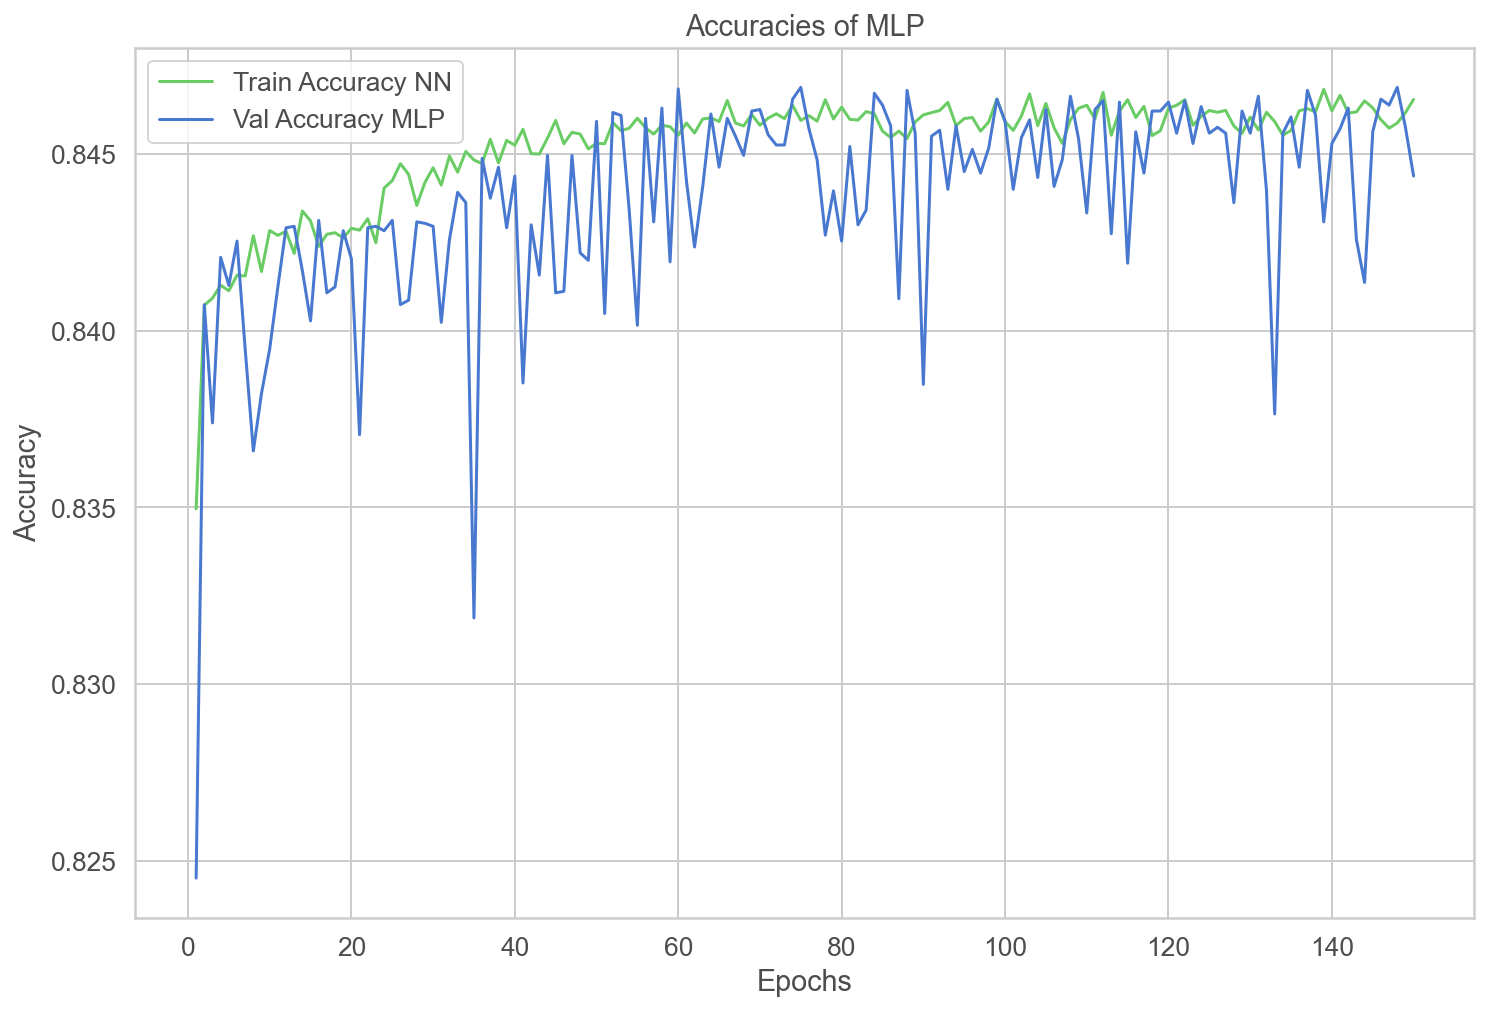

In [425]:
import matplotlib.pyplot as plt
#plt.style.use("seaborn-dark")
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '1.0'#'#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.3'  # very light grey
epochs_range = np.arange(1,EPOCH+1)
plt.plot(epochs_range, train_acc_per_epoch, 'g', label='Train Accuracy NN')
plt.plot(epochs_range, val_acc_per_epoch, 'b', label='Val Accuracy MLP')
#plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background
plt.title('Accuracies of MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [423]:
flat_predicted = [item for sublist in predicted_list for item in sublist]
print(len(y_test))

23941


In [424]:
predictions_df = pd.DataFrame()
predictions_df['predicted'] = flat_predicted
predictions_df['true value'] = y_test
predictions_df.to_csv('predicted_csv.csv', sep='\t', encoding='utf-8')
